# Trabalho de Sobredispersão em Modelos de Contagem
1. Análise exploratória dos dados
2. Ajuste do modelo de Poisson
3. Teste de sobredispersão
4. Ajuste do modelo binomial negativo
5. Análise de excesso de zeros e comparação de modelos

# RecreationDemand

## Descrição Geral

O conjunto de dados `RecreationDemand` contém informações coletadas em 1980 por meio de uma pesquisa com 2.000 proprietários de barcos de lazer registrados em 23 condados do leste do Texas, EUA. A pesquisa visava entender a demanda por viagens recreativas de barco ao Lago Somerville, além de coletar dados sobre características dos entrevistados e custos associados a visitas a outros lagos da região.

O conjunto é frequentemente utilizado em análises econométricas de dados de contagem, como modelos de Poisson, binomial negativa, modelos zero-inflados e modelos hurdle.

## Estrutura dos Dados

* **Observações**: 659
* **Variáveis**: 8

## Descrição das Variáveis

- **trips**: Número de viagens recreativas de barco realizadas ao Lago Somerville.
- **quality**: Avaliação subjetiva da qualidade das instalações do lago, em uma escala de 1 a 5. Para indivíduos que não visitaram o lago, o valor é 0.
- **ski**: Indica se o indivíduo praticou esqui aquático no lago (`sim` ou `não`).
- **income**: Renda anual da família do entrevistado, em milhares de dólares americanos (USD).
- **userfee**: Indica se o indivíduo pagou uma taxa anual de uso no Lago Somerville (`sim` ou `não`).
- **costC**: Despesa estimada ao visitar o Lago Conroe, em dólares americanos (USD).
- **costS**: Despesa estimada ao visitar o Lago Somerville, em dólares americanos (USD).
- **costH**: Despesa estimada ao visitar o Lago Houston, em dólares americanos (USD).

### Observações

- A variável "quality" inclui o valor 0 para não visitantes, o que pode reduzir sua média, conforme explicado em Seller et al. (1985).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
recreation_demand = sm.datasets.get_rdataset("RecreationDemand", "AER", cache=True)

## 1. Análise Exploratória dos Dados

Vamos explorar o conjunto de dados `RecreationDemand`, verificando a estrutura, estatísticas descritivas e a relação entre as variáveis. O objetivo é identificar possíveis covariáveis e avaliar a adequação do modelo de Poisson.


In [3]:
data = recreation_demand.data
# data.to_csv("./data/RecreationDemand.csv", index=False)
data.head()

,trips,quality,ski,income,userfee,costC,costS,costH
0,0,0,yes,4,no,67.59,68.620,76.800
1,0,0,no,9,no,68.86,70.936,84.780
2,0,0,yes,5,no,58.12,59.465,72.110
3,0,0,no,2,no,15.79,13.750,23.680
4,0,0,yes,3,no,24.02,34.033,34.547


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   trips    659 non-null    int64  
 1   quality  659 non-null    int64  
 2   ski      659 non-null    object 
 3   income   659 non-null    int64  
 4   userfee  659 non-null    object 
 5   costC    659 non-null    float64
 6   costS    659 non-null    float64
 7   costH    659 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 41.3+ KB


In [5]:
data.describe()

,trips,quality,income,costC,costS,costH
count,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000
mean,2.244310,1.418816,3.852807,55.423704,59.928053,55.990303
std,6.292475,1.811986,1.851937,46.682648,46.376676,46.133211
min,0.000000,0.000000,1.000000,4.340000,4.767000,5.700000
25%,0.000000,0.000000,3.000000,28.240000,33.312000,28.963500
50%,0.000000,0.000000,3.000000,41.190000,47.000000,42.380000
75%,2.000000,3.000000,5.000000,69.675000,72.573500,68.560000
max,88.000000,5.000000,9.000000,493.770000,491.547000,491.049000


In [6]:
data["ski"].value_counts()

ski
no     417
yes    242
Name: count, dtype: int64

In [7]:
data["userfee"].value_counts()

userfee
no     646
yes     13
Name: count, dtype: int64

In [8]:
data["ski"] = data["ski"].apply(lambda x: int(x == "yes"))
data["userfee"] = data["userfee"].apply(lambda x: int(x == "yes"))

In [9]:
# used_cols = [col for col in data.columns if col not in ["ski", "userfee"]]

correlation_matrix = data.corr()

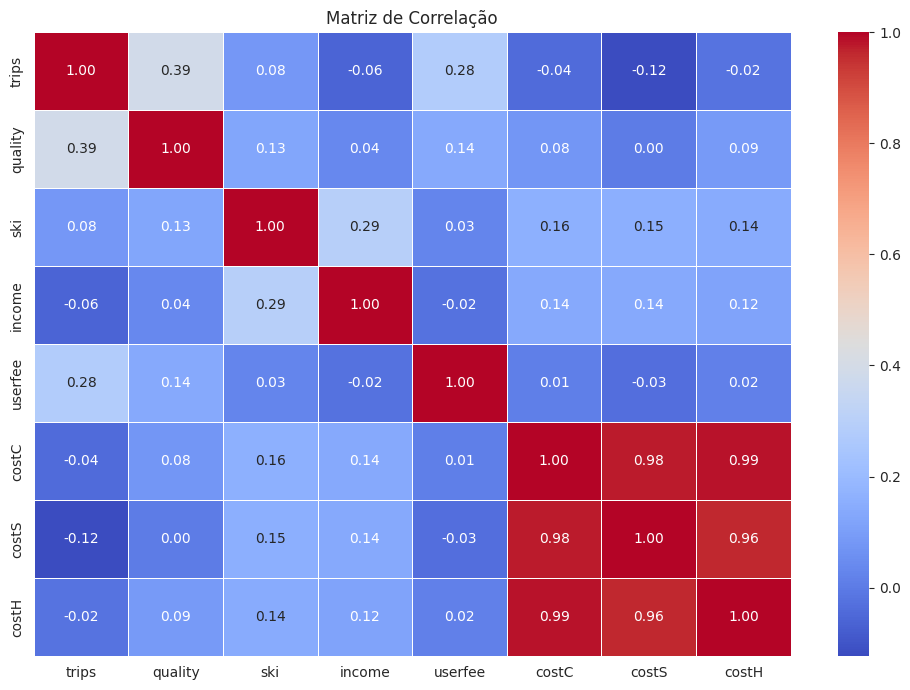

In [10]:
plt.figure(figsize=(10, 7))
sns.set_style(style="white")
heatmap = sns.heatmap(
    correlation_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
)
plt.title("Matriz de Correlação")

plt.tight_layout()

plt.show()

## 2. Análise do modelo de Poisson